<a href="https://colab.research.google.com/github/Thiago-Reis-Porto/Timm/blob/main/Pipeline_geostatistica_Timm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sub-Bacia Hidrografica Sanga Ellert


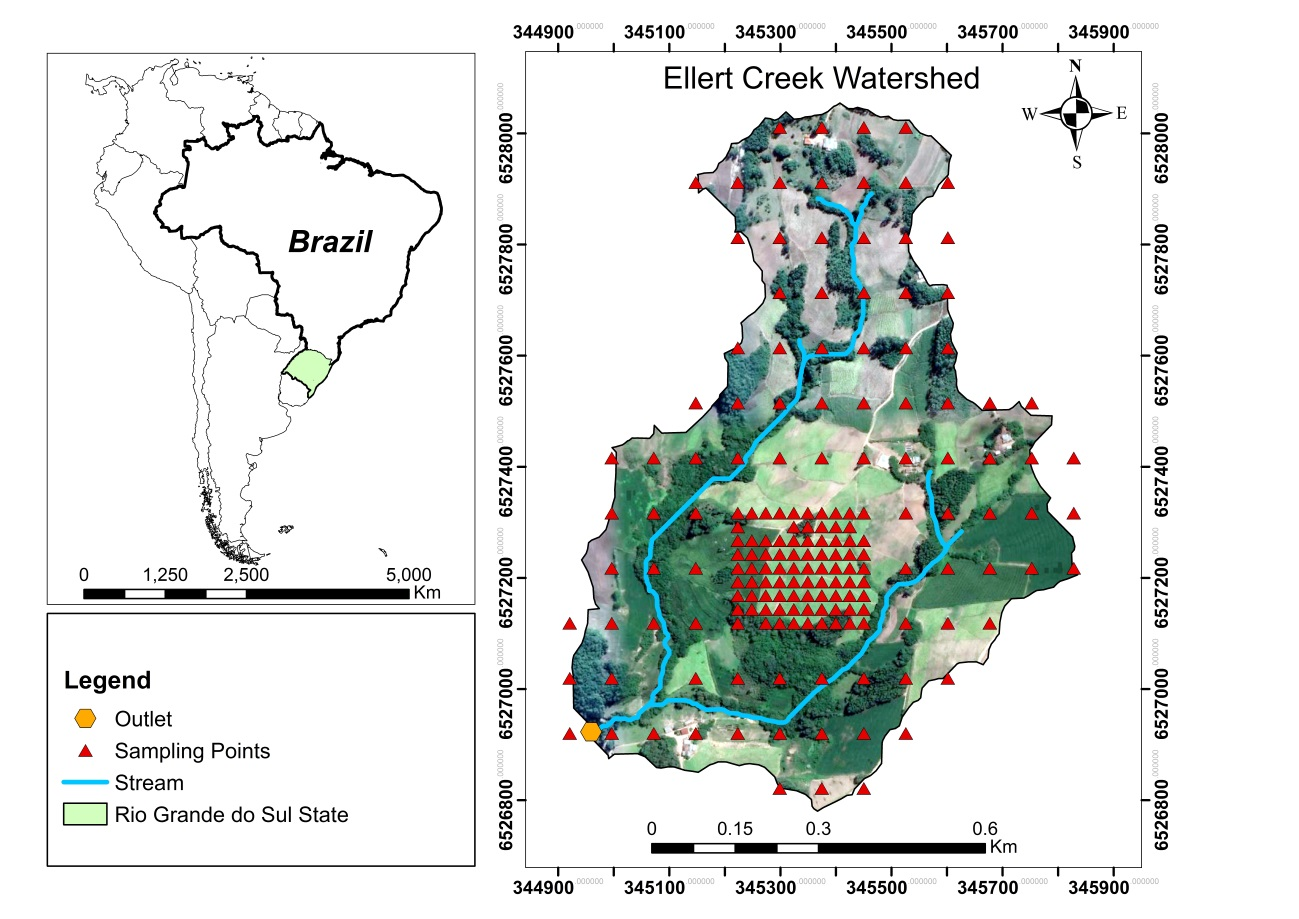

#Importações

In [ ]:
%%capture
!pip3 install pygeostat
import pygeostat as gs
import numpy as np
import os, sys, time
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Path, PathPatch, Polygon
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable

print ('pygeostat versão {}'.format(gs.__version__))
print ('numpy versão {}'.format(np.__version__))

!wget https://raw.githubusercontent.com/Thiago-Reis-Porto/Timm/main/Data_Sanga/datasanga2D.txt
!wget https://raw.githubusercontent.com/Thiago-Reis-Porto/Timm/main/Data_Sanga/contorno_BHSE.csv

#Utilitarios(Funções):

In [ ]:
def plot_krig(kt3d_output_file, infer_griddef, contourn):

  v = np.loadtxt(kt3d_output_file, skiprows=4)
  v = v[:, 0] # 1a coluna é a estimativa

  # trocar os negativos pra NaN
  v[v<0] = np.nan

  ny = infer_griddef.ny
  nx = infer_griddef.nx
  nz = infer_griddef.nz
  xo = infer_griddef.xmn
  yo = infer_griddef.ymn
  dx = infer_griddef.xsiz
  dy = infer_griddef.ysiz

  m = v.reshape((nz, ny, nx))
  xvec = np.arange(xo, xo+(nx+1)*dx, dx) 
  yvec = np.arange(yo, yo+(ny+1)*dy, dy)

  # como o grid é 3d precisamos escolher uma 'folha' pra plotar m[0, :, :]
  # plt.pcolormesh(xvec - dx/2, yvec - dy/2, m[0, :, :], shading='auto')
  #ax.add_patch(patch)
  fig, ax = plt.subplots()
  # fig.tight_layout()
  frame = m[0, :, :]

  pc = ax.pcolormesh(xvec - dx/2, yvec - dy/2, m[0, :, :], shading='auto')
  ax.set_xlabel('Y', fontsize=18)
  ax.set_ylabel('X', fontsize=18)
  ax.set_title('Ksat Estimate', fontsize=18)
  path = Polygon(xy, transform=ax.transData)

  pc.set_clip_path(path)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.2)

  fig.colorbar(pc, cax=cax, orientation='vertical')
  ax.use_sticky_edges=False
  ax.margins(0.1)
  ax.axis('equal')
  # ax.plot(x,y,lw=1.5, c='r')
  plt.show()

In [ ]:
def plor_krig_var(kt3d_output_file, infer_griddef):
  
  ny = infer_griddef.ny
  nx = infer_griddef.nx
  nz = infer_griddef.nz
  xo = infer_griddef.xmn
  yo = infer_griddef.ymn
  dx = infer_griddef.xsiz
  dy = infer_griddef.ysiz

  v = np.loadtxt(kt3d_output_file, skiprows=4)
  v = v[:, 1] # 1a coluna é a variância de krigagem

  # trocar os negativos pra NaN
  v[v<0] = np.nan

  m = v.reshape((nz, ny, nx))
  xvec = np.arange(xo, xo+(nx+1)*dx, dx) 
  yvec = np.arange(yo, yo+(ny+1)*dy, dy)

  plt.clf()
  plt.pcolormesh(xvec - dx/2, yvec - dy/2, m[0, :, :], shading='auto')
  plt.xlabel('East', fontsize=18)
  plt.ylabel('North', fontsize=18)
  plt.title('Ksat Estimate Variance', fontsize=18)
  plt.colorbar()
  plt.show()

##Função aqui para plotar a modelagem e o variograma experimental

In [ ]:
def plot_gamv_output(filename, filename_vmodel=None, type_xaxis='lag', lag_dist_gamv=None, lag_dist_vmodel=None):
    '''
    # Vou considerar uma saida tipica como a seguir. Os dados ficam em linhas com 6 valores
    Semivariogram           tail:Fines        head:Fines         direction  1 
   1        0.000      0.00000     5808       28.70730       28.70730
    '''
    
    # Para o vmodel gravado o template eh [estranho que tem duas linhas '1']
    '''
   Model Variogram for Direction:  1
   1     0.000      0.00000      4      1.00000      1.00000
   1     0.000      0.00000      4      1.00000      1.00000
   2     1.000      0.01500      4      0.98500      0.98500
   3     2.000      0.03000      4      0.97000      0.97000
    '''
    
    # Esse bloco eh pra ler o gamv
    file_ = open(filename)
    direcoes_count = 0
    nlag = 0
    vetor_dados_1_direcao_gamv = list()
    matriz_dados_direcoes_gamv = list()
    for line in file_.readlines():
      if len(line.split()) == 6:
            # dados
            data = float(line.split()[2])
            nlag = nlag + 1
            vetor_dados_1_direcao_gamv.append(data)
      else:
        # nova direcao
        direcoes_count = direcoes_count + 1
        if direcoes_count > 1: # isso precisa pq a direcao 1 não tem dados ainda
          matriz_dados_direcoes_gamv.append(vetor_dados_1_direcao_gamv)
        vetor_dados_1_direcao_gamv = list()
        nlag = 0
        
    matriz_dados_direcoes_gamv.append(vetor_dados_1_direcao_gamv) # a ultima direcao
    
    m_gamv = np.array(matriz_dados_direcoes_gamv)
    print ('O arquivo {} lido tem {} lags e {} direcoes.'.format(filename, m_gamv.shape[1], m_gamv.shape[0]))

    # Esse bloco eh pra ler o vmodel
    m_vmodel = None
    if filename_vmodel and lag_dist_vmodel:
        file_ = open(filename_vmodel)
        direcoes_count = 0
        nlag = 0
        vetor_dados_1_direcao_vmodel = list()
        matriz_dados_direcoes_vmodel = list()
        flag_pulei_1a_linha = False
        for line in file_.readlines():
          if flag_pulei_1a_linha == False:
            flag_pulei_1a_linha = True
            continue
          if len(line.split()) == 6:
                # dados
                data = float(line.split()[2])
                nlag = nlag + 1
                vetor_dados_1_direcao_vmodel.append(data)
          else:
            # nova direcao
            direcoes_count = direcoes_count + 1
            if direcoes_count > 1: # isso precisa pq a direcao 1 não tem dados ainda
              matriz_dados_direcoes_vmodel.append(vetor_dados_1_direcao_vmodel)
            vetor_dados_1_direcao_vmodel = list()
            nlag = 0

        matriz_dados_direcoes_vmodel.append(vetor_dados_1_direcao_vmodel) # a ultima direcao

        m_vmodel = np.array(matriz_dados_direcoes_vmodel)
        print ('O arquivo {} lido tem {} lags e {} direcoes.'.format(filename_vmodel, m_vmodel.shape[1], m_vmodel.shape[0]))

    plt.figure(figsize=(7, 4))
    plt.clf()
    plt.title('Variograma experimental, arquivo {}'.format(filename))
    plt.ylabel('$\gamma(h)$')
    if type_xaxis.lower() == 'lag':
      plt.xlabel('lag (n)')
    elif type_xaxis.lower() == 'dist' or type_xaxis.lower() == 'distance':
      plt.xlabel('distance')
    else:
      print ('Nao entendi o parâmetro type_xaxis. Dever ser \'lag\' ou \'dist\' ')

    for i, direcao in enumerate(m_gamv):
        if type_xaxis.lower() == 'lag':
          plt.plot(np.arange(len(direcao))+0, direcao, '-', label='direcao {}'.format(i))
        elif type_xaxis.lower() == 'dist' or type_xaxis.lower() == 'distance':
          plt.plot((np.arange(len(direcao))+0)*lag_dist_gamv, direcao, '-', label='direcao {}'.format(i)) 
        else:
          print ('Nao entendi o parâmetro type_xaxis. Dever ser \'lag\' ou \'dist\' ')

    if filename_vmodel and lag_dist_vmodel:
        for i, direcao in enumerate(m_vmodel):
            if type_xaxis.lower() == 'lag':
              plt.plot(np.arange(len(direcao))+0, direcao, '-', label='vmodel {}'.format(i))
            elif type_xaxis.lower() == 'dist' or type_xaxis.lower() == 'distance':
              plt.plot((np.arange(len(direcao))+0)*lag_dist_vmodel, direcao, '-', label='vmodel {}'.format(i)) 
            else:
              print ('Nao entendi o parâmetro type_xaxis. Dever ser \'lag\' ou \'dist\' ')

        
    plt.legend()
    plt.show()

# se eu quiser plotar só o var exp
#plot_gamv_output(output_gamv)


#Carregando e vizualizando os Dados da bacia

In [ ]:
#arquivo de dados
file_data = 'datasanga2D.txt'

#arquivos de saída e temporários
work_folder = 'work-temp'

#vamos criar a pasta caso não exista
if not os.path.isdir(work_folder):
  os.mkdir(work_folder)
else:
  print ('Pasta de trabalho \'{}\' já existe.'.format(work_folder))

Pasta de trabalho 'work-temp' já existe.


In [ ]:
dados = np.loadtxt('datasanga2D.txt', skiprows = 13)
print(dados)

[[3.45298870e+05 6.52682130e+06 2.10000000e-01 ... 4.67500000e+01
  3.44300000e+01 6.40000000e-01]
 [3.45374490e+05 6.52682130e+06 8.20000000e-01 ... 3.25200000e+01
  5.68700000e+01 2.40000000e-01]
 [3.45450100e+05 6.52682130e+06 7.00000000e-02 ... 2.68700000e+01
  5.25200000e+01 3.80000000e-01]
 ...
 [3.45450100e+05 6.52719312e+06 3.00000000e-02 ... 1.57500000e+01
  6.11500000e+01 1.60000000e+00]
 [3.45450100e+05 6.52716834e+06 1.24000000e+00 ... 1.82400000e+01
  7.39900000e+01 1.60000000e+00]
 [3.45450100e+05 6.52714355e+06 2.70000000e-01 ... 1.64700000e+01
  7.31500000e+01 1.61000000e+00]]


In [ ]:
datafl = gs.DataFile(file_data)
print (type(datafl))
datafl.head()

<class 'pygeostat.data.data.DataFile'>


,X,Y,Ksat,Ds,PT,Mic,Mac,Argila,Silte,Areia,CO
0,345298.87,6526821.30,0.21,1.28,51.72,24.66,27.07,18.83,46.75,34.43,0.64
1,345374.49,6526821.30,0.82,1.48,44.13,13.78,30.35,10.61,32.52,56.87,0.24
2,345450.10,6526821.30,0.07,1.73,34.87,20.79,14.08,20.61,26.87,52.52,0.38
3,344920.79,6526920.45,0.69,1.36,48.54,21.84,26.70,20.03,30.93,49.05,0.36
4,344996.41,6526920.45,0.09,1.57,40.71,18.87,21.85,13.59,30.15,56.26,0.35


In [ ]:
df = datafl.data.copy()
print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       179 non-null    float64
 1   Y       179 non-null    float64
 2   Ksat    179 non-null    float64
 3   Ds      179 non-null    float64
 4   PT      179 non-null    float64
 5   Mic     179 non-null    float64
 6   Mac     179 non-null    float64
 7   Argila  179 non-null    float64
 8   Silte   179 non-null    float64
 9   Areia   179 non-null    float64
 10  CO      179 non-null    float64
dtypes: float64(11)
memory usage: 15.5 KB
None


In [ ]:
df.describe()

,X,Y,Ksat,Ds,PT,Mic,Mac,Argila,Silte,Areia,CO
count,179.00000,1.790000e+02,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,345358.29419,6.527305e+06,0.811564,1.411117,46.752570,20.699385,26.053128,19.616257,23.541006,56.842682,1.078212
std,178.09760,2.622882e+02,0.807029,0.174240,6.584472,5.056151,7.813746,7.872365,8.829724,11.973867,0.502236
min,344920.79000,6.526821e+06,0.010000,0.810000,33.760000,7.300000,6.440000,4.720000,8.760000,30.220000,0.130000
25%,345248.46000,6.527144e+06,0.205000,1.340000,42.360000,16.985000,21.230000,13.990000,15.285000,48.165000,0.630000
50%,345349.28000,6.527243e+06,0.530000,1.420000,46.250000,20.380000,26.460000,18.940000,24.780000,56.300000,1.240000
75%,345450.10000,6.527416e+06,1.210000,1.530000,49.435000,23.400000,30.950000,23.125000,30.170000,65.840000,1.460000
max,345828.18000,6.528011e+06,3.760000,1.760000,69.540000,47.540000,53.700000,52.710000,50.960000,83.110000,2.660000


In [ ]:
df.isna()

,X,Y,Ksat,Ds,PT,Mic,Mac,Argila,Silte,Areia,CO
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
174,False,False,False,False,False,False,False,False,False,False,False
175,False,False,False,False,False,False,False,False,False,False,False
176,False,False,False,False,False,False,False,False,False,False,False
177,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
print ('Lista de variáveis: {}'.format(datafl.variables))
print ('Lista de coordenadas: {}'.format(datafl.xyz)) 

Lista de variáveis: ['Ksat', 'Ds', 'PT', 'Mic', 'Mac', 'Argila', 'Silte', 'Areia', 'CO']
Lista de coordenadas: ['X', 'Y', None]


findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


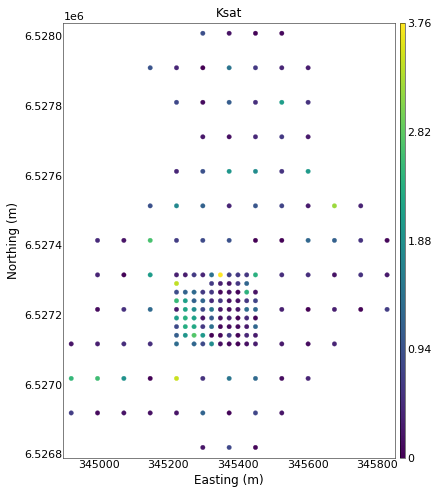

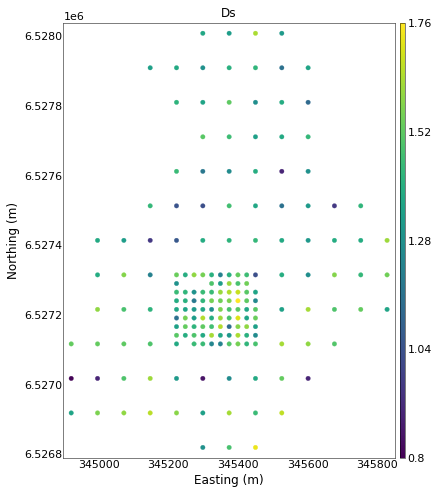

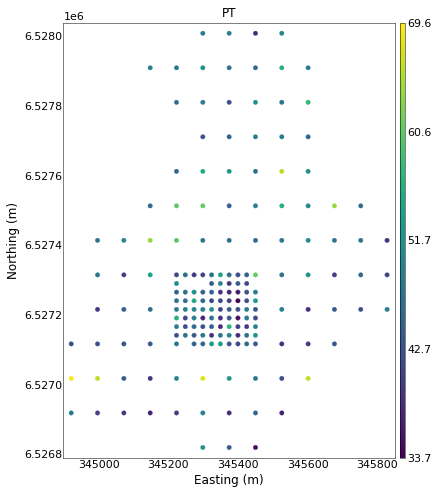

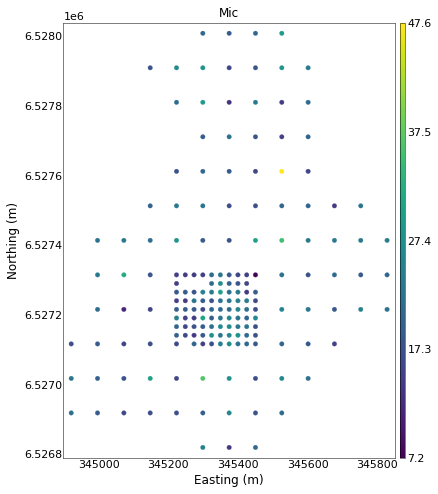

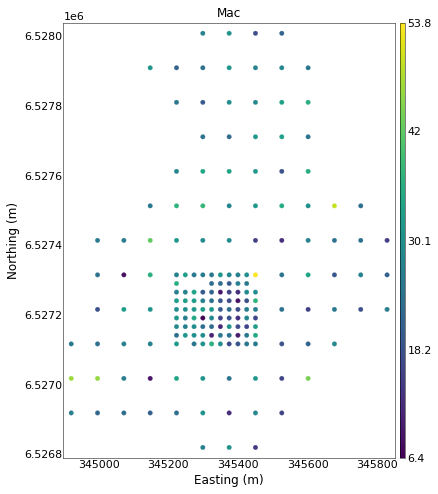

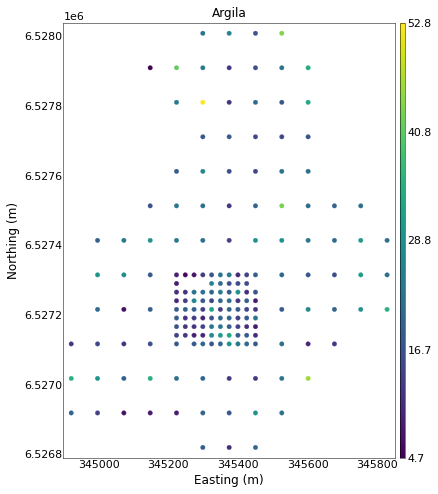

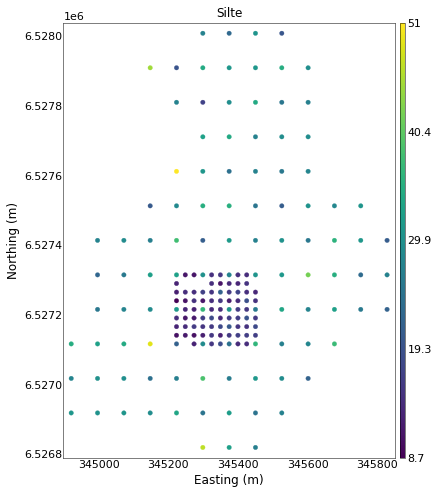

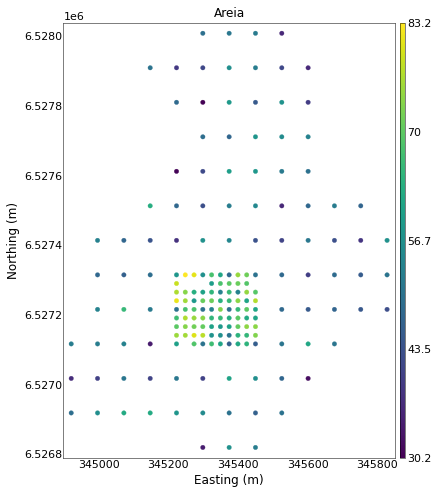

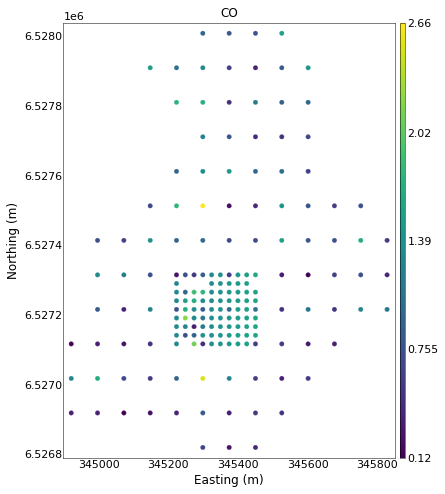

In [ ]:
# O pygeostat tem um locmap 'empacotado'
for var in datafl.variables:
  gs.location_plot(datafl, var=var) 

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


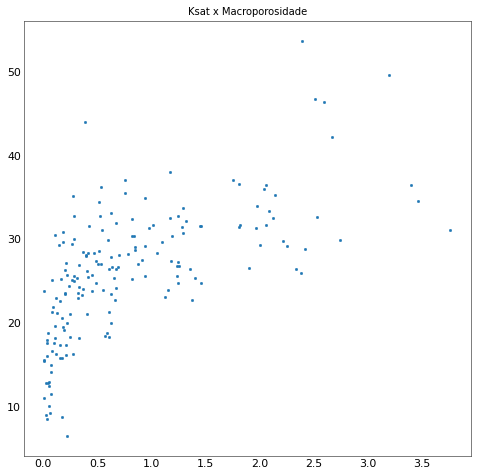

In [ ]:
# exemplo de scatter plot ksat x macro # como plotar o scatter de ksat com as demais em um só comando ?
plt.title('Ksat x Macroporosidade')
plt.scatter(df['Ksat'], df['Mac'], s=7);

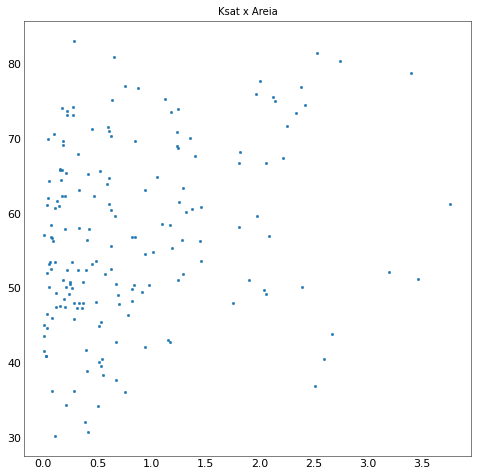

In [ ]:
plt.title('Ksat x Areia')
plt.scatter(df['Ksat'], df['Areia'], s=7);

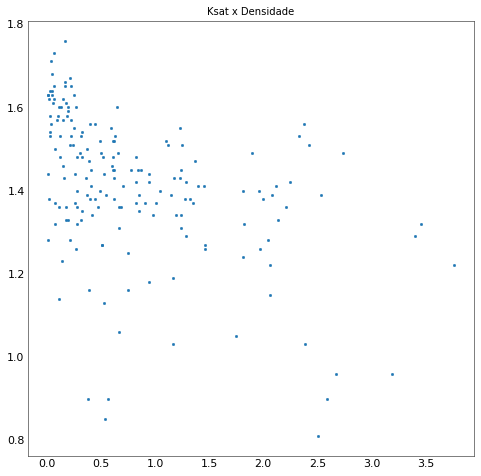

In [ ]:
plt.title('Ksat x Densidade')
plt.scatter(df['Ksat'], df['Ds'], s=7);

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


<Figure size 576x576 with 0 Axes>

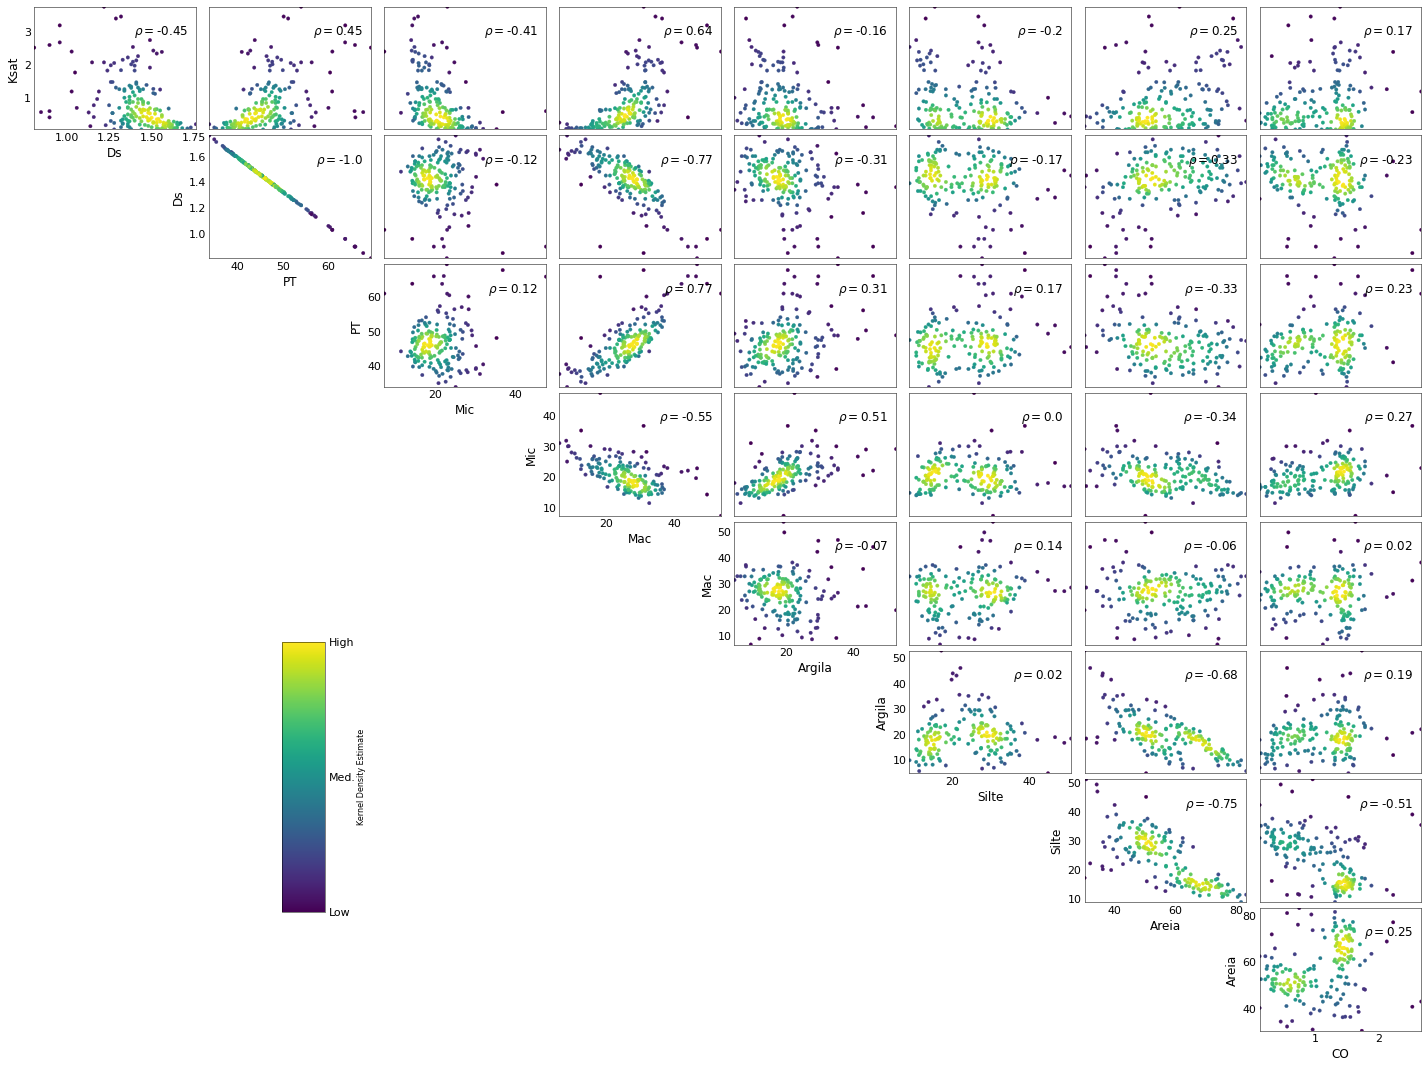

In [ ]:
plt.figure()
_ = gs.scatter_plots(datafl,stat_xy=(0.95, 0.95), pad=(-2, -2), s=12, figsize=(20,15));

##Historiogramas

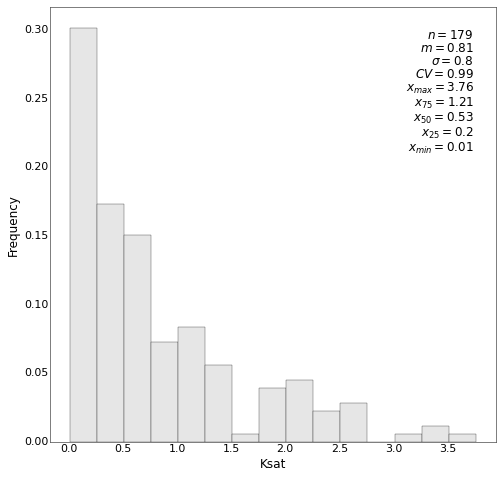

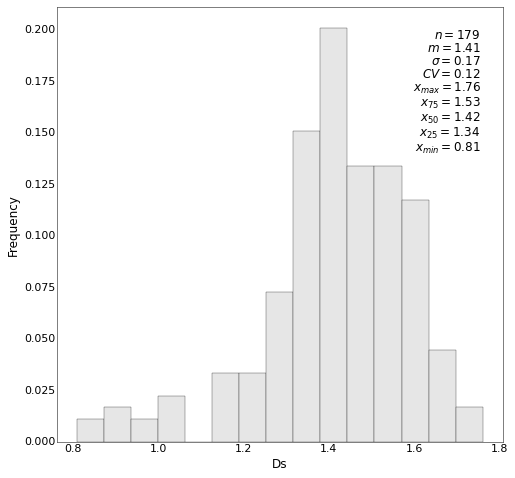

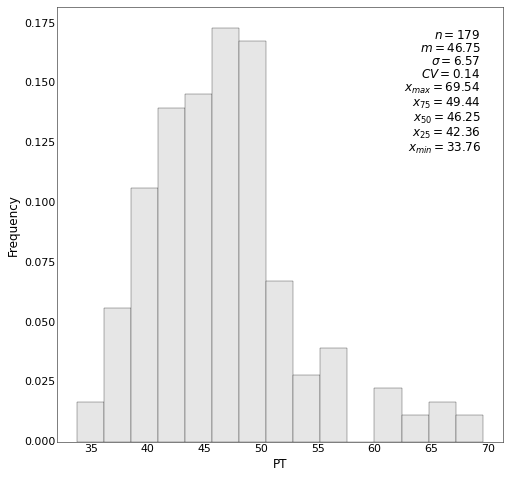

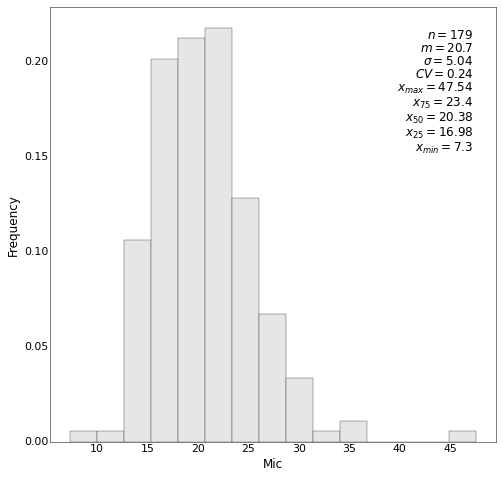

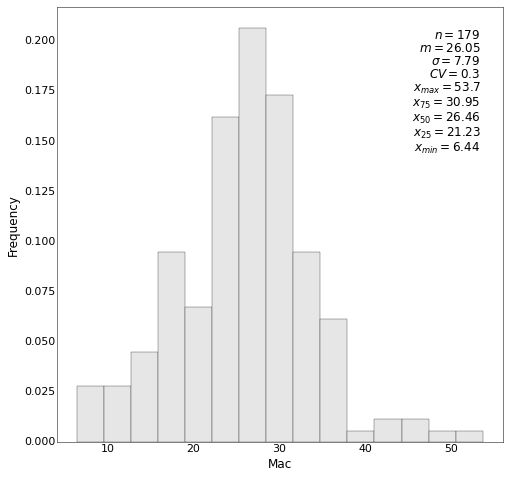

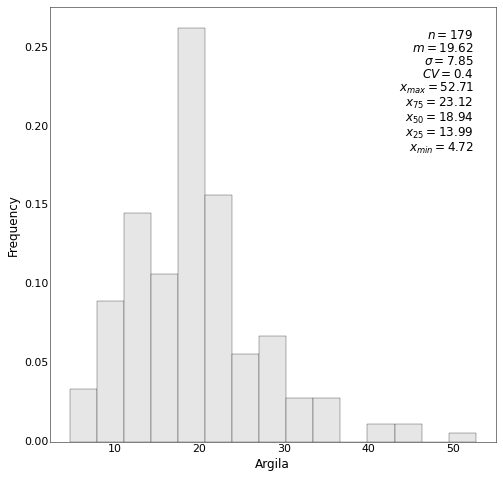

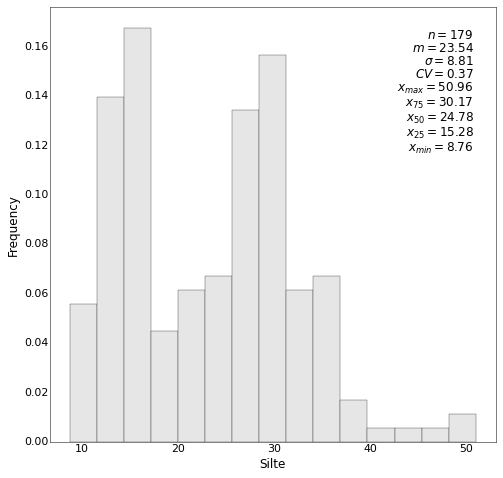

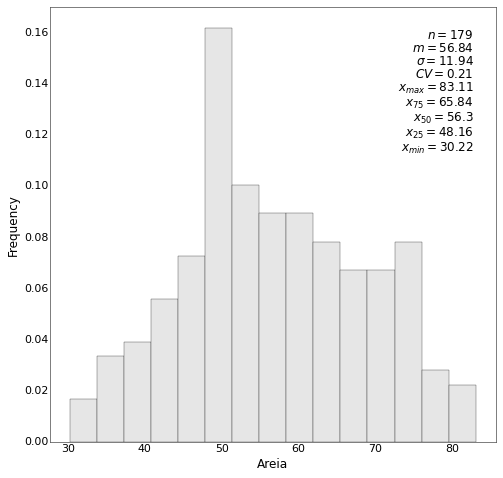

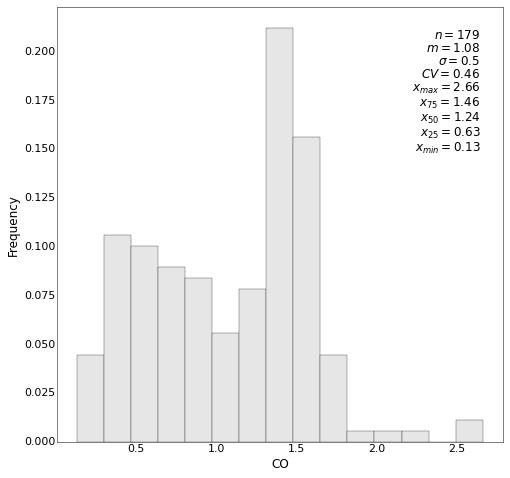

In [ ]:
#plotando os histogramas de cada variável
for var in datafl.variables:
  gs.histogram_plot(datafl, var=var)

#Uso de Executaveis GSLib

In [ ]:
#vamos checar os executáveis do gslib acessíveis
print (gs.list_executable())

[]


In [ ]:
# Funcionalidade do pygeostat, cálculo dos n vizinhos mais próximos
datafl.spacing(n_nearest=2)
datafl.head()

,X,Y,Ksat,Ds,PT,Mic,Mac,Argila,Silte,Areia,CO,Data Spacing (m)
0,345298.87,6526821.30,0.21,1.28,51.72,24.66,27.07,18.83,46.75,34.43,0.64,87.385
1,345374.49,6526821.30,0.82,1.48,44.13,13.78,30.35,10.61,32.52,56.87,0.24,75.615
2,345450.10,6526821.30,0.07,1.73,34.87,20.79,14.08,20.61,26.87,52.52,0.38,87.380
3,344920.79,6526920.45,0.69,1.36,48.54,21.84,26.70,20.03,30.93,49.05,0.36,87.390
4,344996.41,6526920.45,0.09,1.57,40.71,18.87,21.85,13.59,30.15,56.26,0.35,75.620


In [ ]:
lag_length_h = datafl['Data Spacing (m)'].values.mean()

print('Average data spacing in XY plane: {:.3f}{}'.format(
                                                        lag_length_h,
                                                        gs.Parameters['plotting.unit'],
                                                          ))

Average data spacing in XY plane: 53.349m


In [ ]:
x_range = np.ptp(datafl[datafl.x].values)
y_range = np.ptp(datafl[datafl.y].values)
n_lag_x =  np.ceil((x_range * 0.5) /  lag_length_h)
n_lag_y =  np.ceil((y_range * 0.5) /  lag_length_h)
lag_tol_h = lag_length_h * 0.6

print ('x_range: {:.5}, y_range: {:.5}'.format(x_range, y_range))
print ('n_lag_x: {}, n_lag_y: {}'.format(n_lag_x, n_lag_y))
print ('lag_tol_h: {}'.format(lag_tol_h))

x_range: 907.39, y_range: 1189.8
n_lag_x: 9.0, n_lag_y: 12.0
lag_tol_h: 32.00965637731256


In [ ]:
# pasta dos executaveis
exec_path = str(os.path.join(os.path.dirname(gs.__file__), 'executable'))

if len(os.listdir(exec_path))<2:
    # download dos executaveis
    gs.get_executable()

print (f'Pasta dos executáveis: {exec_path}')
!chmod -R +x {exec_path} # permissão de execução para os arquivos

# vamos ver o que tem agora
print ('###')
print ('Arquivos na pasta de executáveis:')
for file_ in os.listdir(exec_path):
  print (file_)

The software is available under gslib license agreement (http://www.gslib.com)
Pasta dos executáveis: /usr/local/lib/python3.7/dist-packages/pygeostat/executable
###
Arquivos na pasta de executáveis:
ik3d
vmodel
declus
cokb3d
lusim
gtsim
scatsmth
rotcoord
scatplt
pixelplt
anneal
nscore
sisim_lm
sisim
addcoord
kb2d
sgsim
varmap
pfsim
backtr
trans
bicalib
plotem
qpplt
histplt
gam
bivplt
sisim_gs
vargplt
kt3d
postik
postsim
bigaus
draw
gamv
sasim
probplt
histsmth
ellipsim
locmap
Info.txt


In [ ]:
gamv = gs.Program('gamv')
print (os.path.basename(datafl.flname))

Unable to find the provided program! Trying to use the executable pool shipped with pygeostat!
datasanga2D.txt


In [ ]:
datafl_input =(file_data)

## # o arquivo de output do gamv, dentro da pasta work folder
output_gamv = os.path.join(work_folder, 'output_gamv.out')
#output_gamv = os.path.join('work-temp/output_gamv.out')



## # definições para o variograma
lag_gamv_dist = 10
n_lags_gamv = 20

par_string = f'''
Parameters for GAMV
*******************

START OF PARAMETERS:
{datafl_input}               -file with data
1   2   0                         -   columns for X, Y, Z coordinates
1   3   3                         -   number of variables,col numbers
-989.0     1.0e21                -   trimming limits
{output_gamv}                          -file for variogram output
{n_lags_gamv}                                -number of lags
{lag_gamv_dist}                              -lag separation distance
10.0                               -lag tolerance
4                                 -number of directions
0.0  22.50 50.0 0.0  22.50   50.0  -azm,atol,bandh,dip,dtol,bandv
22.5  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv
45.0  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv
67.6  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variograms
1   1  1                          -tail var., head var., variogram type
'''

gamv.run(par_string)

Calling:  ['/usr/local/lib/python3.7/dist-packages/pygeostat/executable/gamv', 'temp']

 GAMV Version: 3.000

  data file = datasanga2D.txt                         
  columns for X,Y,Z =  1 2 0
  number of variables =  1
  columns =  3
  trimming limits =  -989. 1.E+21
  output file = work-temp/output_gamv.out               
  number of lags =  20
  lag distance =  10.
  lag tolerance =  10.
  number of directions =  4
  azm, atol, bandwh =  0. 22.5 50.
  dip, dtol, bandwd =  0. 22.5 50.
  azm, atol, bandwh =  22.5 22.5 50.
  dip, dtol, bandwd =  0. 22.5 50.
  azm, atol, bandwh =  45. 22.5 50.
  dip, dtol, bandwd =  0. 22.5 50.
  azm, atol, bandwh =  67.6 22.5 50.
  dip, dtol, bandwd =  0. 22.5 50.
  flag to standardize sills =  1
  number of variograms =  1
  tail,head,type =  1 1 1

 maxdat =  179
 Variable number  1
   Number   =  179
   Average  =  0.81156427
   Variance =  0.6476568

 Variogram  1 Semivariogram          :  tail=Ksat								 head=Ksat								   
   currently on    

In [ ]:
file_data

'datasanga2D.txt'

In [ ]:
ang_inicial = 0
ang_final = 170
step_angulo = 20

v_ang = np.arange(ang_inicial, ang_final, step_angulo)
print (f'A qtdade de angulos ficou {len(v_ang)}.')
print (v_ang)

string_angulos = f'{len(v_ang)}      -number of directions\n' # começando com o numero de angulos para o gamv
for ang in v_ang:
    string_angulos = string_angulos + f'{ang}  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv\n'
string_angulos = string_angulos[:-1]
print ()
print (string_angulos)

#### Refazendo o arquivo de parametros com os angulos 'automatizados'
datafl_input = file_data

# o arquivo de output do gamv, dentro da pasta work folder
output_gamv = os.path.join(work_folder, 'output_gamv.out')

# definições para o variograma
lag_gamv_dist = 20
n_lags_gamv = 20

par_string_experimental = f'''
Parameters for GAMV
*******************

START OF PARAMETERS:
{datafl_input}               -file with data
1   2   0                         -   columns for X, Y, Z coordinates
1   3   3                         -   number of variables,col numbers
-1.0e21     1.0e21                -   trimming limits
{output_gamv}                          -file for variogram output
{n_lags_gamv}                                -number of lags
{lag_gamv_dist}                              -lag separation distance
10.0                               -lag tolerance
{string_angulos}
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variograms
1   1  1                          -tail var., head var., variogram type
'''

print (par_string)

A qtdade de angulos ficou 9.
[  0  20  40  60  80 100 120 140 160]

9      -number of directions
0  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv
20  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv
40  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv
60  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv
80  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv
100  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv
120  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv
140  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv
160  22.50 50.0 0.0  22.50  50.0  -azm,atol,bandh,dip,dtol,bandv

Parameters for GAMV
*******************

START OF PARAMETERS:
datasanga2D.txt               -file with data
1   2   0                         -   columns for X, Y, Z coordinates
1   3   3                         -   number of variables,col numbers
-989.0     1.0e21                -   trimming limits
work-temp/output_gamv.

##Modelagem com o vmodel para plotar com o variograma experimental


###Modelagem com vmodel

In [ ]:
vmodel = gs.Program('vmodel')

vmodel_output_file = os.path.join(work_folder, 'vmodel_out.dat')

par_string = f'''
Parameters for VMODEL
                  *******
START OF PARAMETERS:
{vmodel_output_file}                   -file for variogram output
4   20                       -number of directions and lags
0.0   0.0    10.0            -azm, dip, lag distance
45.0   0.0    10.0            -azm, dip, lag distance
90.0   0.0    10.0            -azm, dip, lag distance
135.0   0.0    10.0            -azm, dip, lag distance
1    0.1                     -nst, nugget effect
1    0.9  0.0   0.0   0.0    -it,cc,ang1,ang2,ang3
200.0   80.0  10.0    -a_hmax, a_hmin, a_vert
'''

vmodel.run(par_string)

Unable to find the provided program! Trying to use the executable pool shipped with pygeostat!
Calling:  ['/usr/local/lib/python3.7/dist-packages/pygeostat/executable/vmodel', 'temp']

 VMODEL Version: 3.000

  output file = work-temp/vmodel_out.dat                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
  ndir,nlag =  4 20
  azm, dip, lag =  0. 0. 10.
  x,y,z offsets =  0. 10. 0.

  azm, dip, lag =  45. 0. 10.
  x,y,z offsets =  7.071068 7.071068 0.

  azm, dip, lag =  90. 0. 10.
  x,y,z offsets =  10. -4.371139E-7 0.

  azm, dip, lag =  135. 0. 10.
  x,y,z off

O arquivo work-temp/output_gamv.out lido tem 22 lags e 4 direcoes.


findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


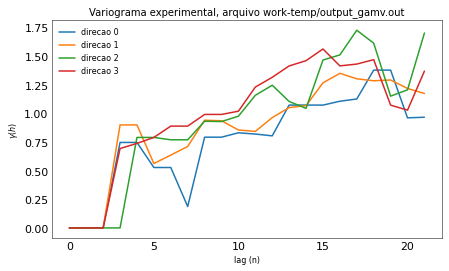

In [ ]:
plot_gamv_output(output_gamv);
#print(output_gamv)

O arquivo work-temp/output_gamv.out lido tem 22 lags e 4 direcoes.
O arquivo work-temp/vmodel_out.dat lido tem 22 lags e 3 direcoes.


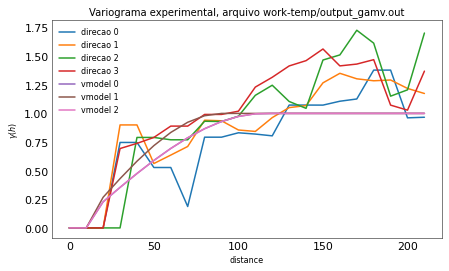

In [ ]:
# se eu quiser plotar o var exp e um modelo com distância
plot_gamv_output(output_gamv,
                 filename_vmodel=vmodel_output_file,
                 type_xaxis='dist',
                 lag_dist_gamv=10,
                 lag_dist_vmodel=10,
                 )

##Krigagem

In [ ]:
#o pygeostat tem uma função 
infer_griddef = datafl.infergriddef(blksize=[5, 5, 0])

# vou dar esse dir no grid inferido pra lembrar como pego as características do grid
print (infer_griddef)

184 344917.5 5.0 
241 6526818.5 5.0 
1 0.5 1.0


In [ ]:
kt3d = gs.Program('kt3d')

kt3d_output_file = os.path.join(work_folder, 'kt3d_out.dat')

#lembrete do input file: datafl_input

Unable to find the provided program! Trying to use the executable pool shipped with pygeostat!


In [ ]:
par_string = f'''
Parameters for KT3D
                  *******************

START OF PARAMETERS:
{datafl_input}              -file with data
0  1  2  0  3  0                 -   columns for DH,X,Y,Z,var,sec var
-98.0   1.0e21                 -   trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
0                             -debugging level: 0,1,2,3
kt3d.dbg                         -file for debugging output
{kt3d_output_file}                         -file for kriged output
{infer_griddef.nx}   {infer_griddef.xmn}    {infer_griddef.xsiz}                  -nx,xmn,xsiz
{infer_griddef.ny}   {infer_griddef.ymn}    {infer_griddef.ysiz}                  -ny,ymn,ysiz
{infer_griddef.nz}   {infer_griddef.zmn}    {infer_griddef.zsiz}                  -nz,zmn,zsiz
1    1      1                    -x,y and z block discretization
1    12                           -min, max data for kriging
0                                -max per octant (0-> not used)
500   500  50                 -maximum search radii
22.5   0.0   0.0                 -angles for search ellipsoid
1     2.302                      -0=SK,1=OK,2=non-st SK,3=exdrift
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.dat                     -gridded file with drift/mean
4                                -  column number in gridded file
1    0.05                         -nst, nugget effect
1    0.95  22.5   0.0   0.0        -it,cc,ang1,ang2,ang3
180.0  55.0  1.0        -a_hmax, a_hmin, a_vert
'''

print (par_string)

kt3d.run(par_string)


Parameters for KT3D
                  *******************

START OF PARAMETERS:
datasanga2D.txt              -file with data
0  1  2  0  3  0                 -   columns for DH,X,Y,Z,var,sec var
-98.0   1.0e21                 -   trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
0                             -debugging level: 0,1,2,3
kt3d.dbg                         -file for debugging output
work-temp/kt3d_out.dat                         -file for kriged output
184   344917.5    5.0                  -nx,xmn,xsiz
241   6526818.5    5.0                  -ny,ymn,ysiz
1   0.5    1.0                  -nz,zmn,zsiz
1    1      1                    -x,y and z block discretization
1    12                           -min, max data for kriging
0                                -max per octant (0-> not used)
500   500  50             

In [ ]:
contorno = pd.read_csv('contorno_BHSE.csv')
xy = contorno.to_numpy()
x, y = zip(*xy)

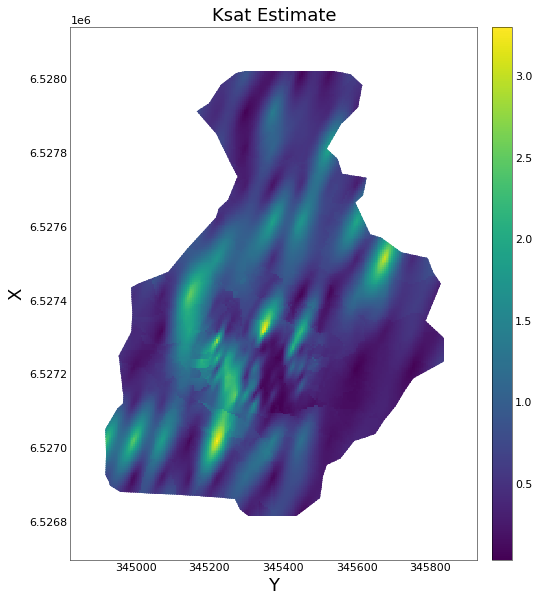

In [ ]:
plot_krig(kt3d_output_file, infer_griddef, contorno);

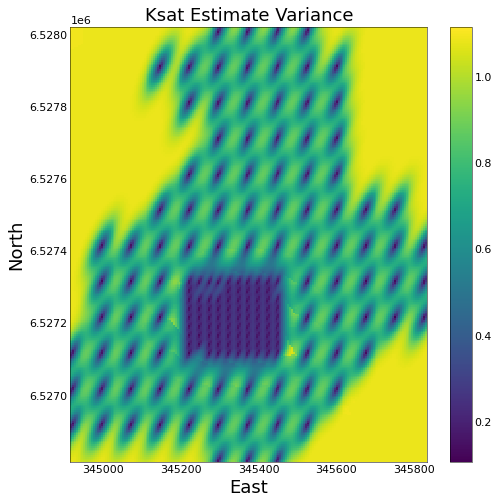

In [ ]:
plor_krig_var(kt3d_output_file, infer_griddef);

In [ ]:
krigfl = gs.DataFile(kt3d_output_file, griddef=datafl.griddef)
# krigfl.data.loc[krigfl["EstimationVariance"] > 0.99, "Estimate"] = np.nan

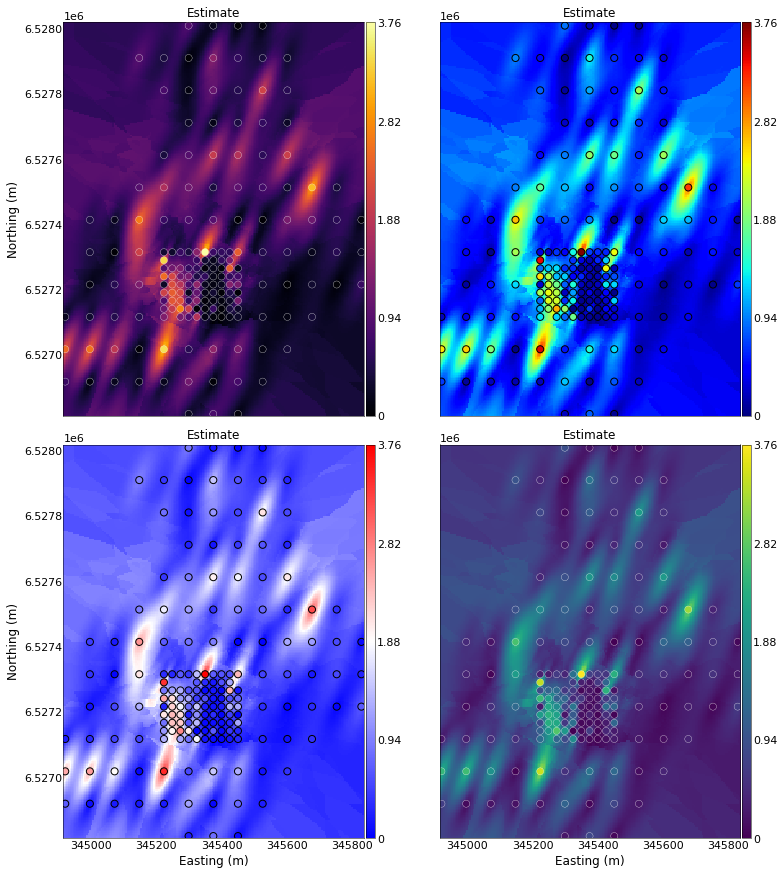

In [ ]:
cmaps = ['inferno', 'jet', 'bwr', 'viridis']
fig, axes = gs.subplots(2, 2, axes_pad=(0.9, 0.4), figsize= (20,15), cbar_mode='each', label_mode='L')
for i, ax in enumerate(axes):
    if cmaps[i] == 'jet' or cmaps[i] == 'bwr': pointkws={'edgecolors':'k', 's':50, 'linewidth':1}
    else: pointkws={'edgecolors':'w', 's':50}
    gs.slice_plot(krigfl, var='Estimate', pointvar='Ksat',pointkws=pointkws,
                     orient='xy', cmap=cmaps[i], ax=ax, pointdata=datafl)

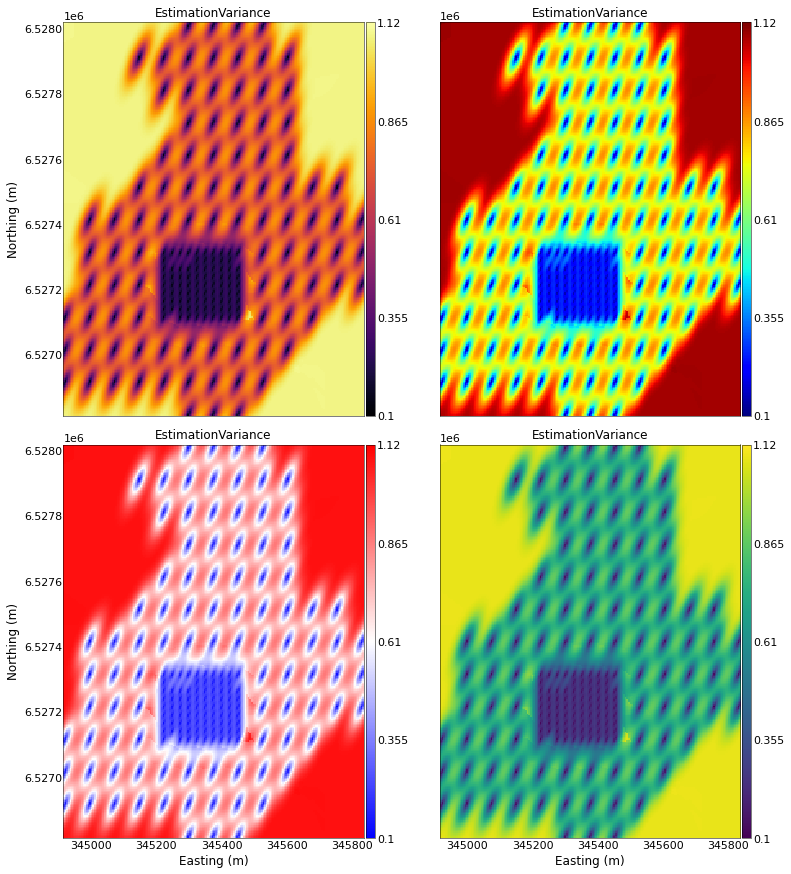

In [ ]:
cmaps = ['inferno', 'jet', 'bwr', 'viridis']
fig, axes = gs.subplots(2, 2, axes_pad=(0.9, 0.4), figsize= (20,15), cbar_mode='each', label_mode='L')
for i, ax in enumerate(axes):
    gs.slice_plot(krigfl, var='EstimationVariance', orient='xy', cmap=cmaps[i], ax=ax, pointdata=datafl, 
                   pointkws={'edgecolors':'k', 's':25})